Grounding Dino for region seed generation from input prompt

In [1]:
import requests
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, infer_device
from transformers import Sam2Processor, Sam2Model, infer_device
import torch
import requests
import cuda
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = infer_device()
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
image_path = "/content/SAM_cats.jpg"
image = Image.open(image_path).convert("RGB")
text_labels = [["Black cat", "Brown cat"]]
inputs = processor(images=image, text=text_labels, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]])
result = results[0]

for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    box = [round(x, 2) for x in box.tolist()]
    print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

Detected black cat with confidence 0.688 at location [388.01, 187.31, 847.32, 547.4]
Detected brown cat with confidence 0.428 at location [130.66, 383.95, 423.44, 560.24]


/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


In [3]:
input_points = []
input_labels = []

for box, score, labels in zip(result["boxes"], result["scores"], result["labels"]):
    x0, y0, x1, y1 = box.tolist()
    cx = (x0 + x1) / 2.0
    cy = (y0 + y1) / 2.0
    input_points.append([cx, cy])
    input_labels.append(1)

input_points = torch.tensor(input_points, dtype=torch.float32).unsqueeze(0)
input_labels = torch.tensor(input_labels, dtype=torch.int64).unsqueeze(0)

print("Input points:", input_points)
print("Input labels:", input_labels)


Input points: tensor([[[617.6649, 367.3553],
         [277.0529, 472.0918]]])
Input labels: tensor([[1, 1]])


SAM-2

In [5]:
device = infer_device()

model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")
print("Shape of input_points before reshaping:", input_points.shape)
print("Shape of input_labels before reshaping:", input_labels.shape)
input_points_reshaped = input_points.unsqueeze(1)
input_labels_reshaped = input_labels.unsqueeze(1)
print("Shape of input_points after reshaping:", input_points_reshaped.shape)
print("Shape of input_labels after reshaping:", input_labels_reshaped.shape)

inputs = processor(images=image, input_points=input_points_reshaped, input_labels=input_labels_reshaped, return_tensors="pt").to(model.device)
with torch.no_grad():
     outputs = model(**inputs, multimask_output=False)

all_masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"])
print(f"Processed {len(all_masks)} images, each with {all_masks[0].shape[0]} objects")

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

Shape of input_points before reshaping: torch.Size([1, 2, 2])
Shape of input_labels before reshaping: torch.Size([1, 2])
Shape of input_points after reshaping: torch.Size([1, 1, 2, 2])
Shape of input_labels after reshaping: torch.Size([1, 1, 2])
Processed 1 images, each with 1 objects


In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.2)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.2)

/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


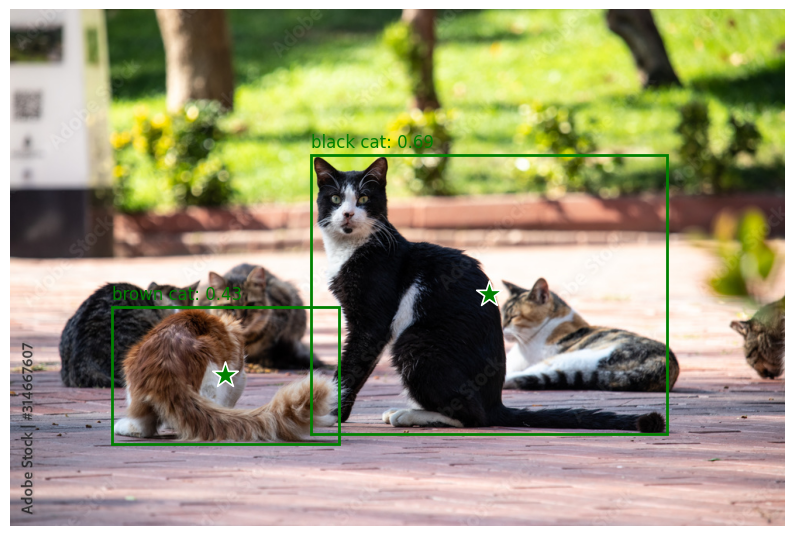

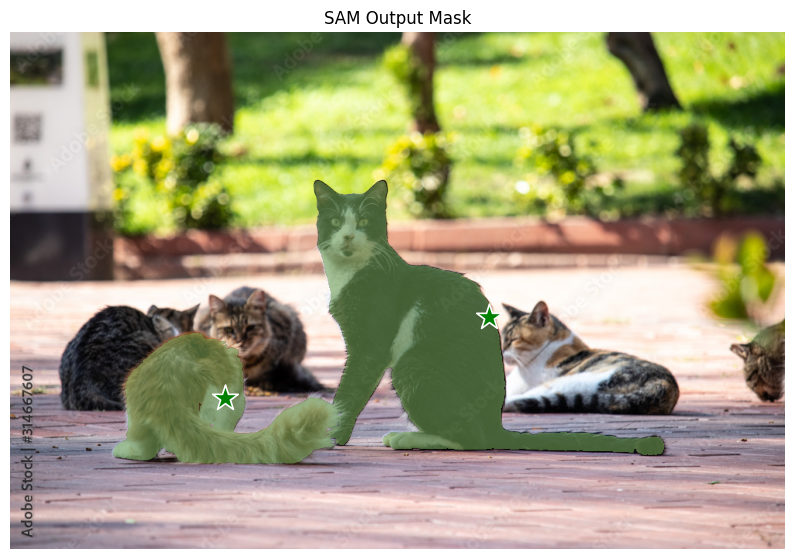

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

# Display of detected objects and labels from GroundingDINO
for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
    box = box.tolist()
    show_box(box, ax)
    ax.text(box[0], box[1] - 10, f"{label}: {score:.2f}", color="green", fontsize=12)

if "input_points" in locals() and "input_labels" in locals() and torch.is_tensor(input_points) and torch.is_tensor(input_labels):
    show_points(input_points.squeeze(0).cpu().numpy(), input_labels.squeeze(0).cpu().numpy(), ax)
else:
    print("GroundingDINO input points/labels not in expected tensor format.")
plt.axis("off")
plt.show()

# Display the output masks from SAM
if "all_masks" in locals() and len(all_masks) > 0 and all_masks[0].shape[0] > 0:
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    show_mask(all_masks[0][0].cpu().numpy(), ax, random_color=True)
    if "input_points" in locals() and "input_labels" in locals() and torch.is_tensor(input_points) and torch.is_tensor(input_labels):
         show_points(input_points.squeeze(0).cpu().numpy(), input_labels.squeeze(0).cpu().numpy(), ax)
    elif 'input_points' in locals() and isinstance(input_points, list) and len(input_points) > 0:
        points_np = np.array(input_points[0]).squeeze(0)
        labels_np = np.array(input_labels[0]).squeeze(0)
        show_points(points_np, labels_np, ax)
    plt.title("SAM Output Mask")
    plt.axis("off")
    plt.show()
else:
    print("SAM output masks not available or empty. Please run the SAM model cell and ensure it produced masks.")